# Feature and more

## Justification rétrospective de certains choix

In [2]:

import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 🌡️ Comprendre les unités : kBtu et émissions de CO₂e

### 🔋 1. Qu’est-ce que le `SiteEnergyUse(kBtu)` ?

La colonne `SiteEnergyUse(kBtu)` indique la **consommation totale d'énergie annuelle d’un bâtiment**, exprimée en **kBtu**, soit :

- **1 kBtu** = 1 000 **British thermal units**
- **1 Btu** ≈ 1 055 joules
- Donc **1 kBtu ≈ 0.293 kWh**

> 👉 Un bâtiment qui consomme 14 172 606 kBtu/an utilise environ **4,15 millions de kWh/an**,  
> soit **autant que 346 maisons individuelles** (moyenne de 12 000 kWh/an par maison).

### 🌪️ 2. Et `SiteEnergyUseWN(kBtu)` ? Quelle différence ?

`SiteEnergyUseWN(kBtu)` signifie **"Site Energy Use - Weather Normalized"**, c’est-à-dire :

> ⚠️ **Consommation énergétique corrigée des variations climatiques**

- Cela représente **ce qu’aurait été la consommation du bâtiment dans une année météo "standardisée"**
- Elle permet de **neutraliser l’effet des hivers plus froids ou des étés plus chauds**
- C’est une **valeur modélisée** utile pour comparer équitablement plusieurs bâtiments d’une même région

> 📌 Exemple :
> - `SiteEnergyUse(kBtu)` = 15 000 000 → année réellement froide
> - `SiteEnergyUseWN(kBtu)` = 12 800 000 → consommation estimée sans ce froid excessif

### 🧪 Dans quels cas cette variable est-elle utile ?

Cette valeur **modélisée** est précieuse dans certains contextes :

| Cas d’usage                                    | Pourquoi l’utiliser ?                                      |
|------------------------------------------------|-------------------------------------------------------------|
| 📊 Benchmark énergétique entre bâtiments       | Supprime les biais dus aux différences climatiques locales |
| 🔁 Suivi d’un bâtiment d’année en année        | Neutralise les hivers anormaux ou étés extrêmes            |
| 🏛️ Politiques publiques / subventions         | Permet une évaluation équitable de l'efficacité réelle     |
| 📈 Études structurelles sur la performance     | Permet de comparer "structurellement" les bâtiments        |

---

### ❌ Pourquoi **ne PAS** l’utiliser ici ?

Notre objectif est de **prédire la consommation d’énergie réelle** (`SiteEnergyUse(kBtu)`) d’un bâtiment.  
Autrement dit, **ce que le compteur mesurera** (et ce qui sera facturé).

Utiliser la version "normalisée climat" serait problématique pour 3 raisons :

1. **Non observable** : on ne connaît pas `SiteEnergyUseWN(kBtu)` avant d’avoir mesuré l’année.
2. **Inclut déjà un modèle** : elle est le résultat d’un ajustement statistique → risque de **data leakage**.
3. **Pas fidèle à la réalité terrain** : notre modèle vise une prédiction "terrain", pas une estimation abstraite.

---

### ✅ En résumé

| Variable               | À utiliser ? | Raisonnement                                  |
|------------------------|--------------|-----------------------------------------------|
| `SiteEnergyUse(kBtu)`  | ✅ OUI       | Cible réelle, mesurée, conforme au terrain    |
| `SiteEnergyUseWN(kBtu)`| ❌ NON       | Valeur modélisée, non disponible en amont     |


### 🌍 3. Qu’est-ce que le `TotalGHGEmissions` ?

La colonne `TotalGHGEmissions` représente les **émissions annuelles totales de gaz à effet de serre**,  
exprimées en **tonnes métriques de CO₂ équivalent** (tCO₂e).

> 👉 Par exemple, **1699.45 tCO₂e/an** équivalent à :
> - **212 maisons individuelles**
> - **~850 vols aller-retour Paris – New York**


### 🔁 4. Comment sont calculées les émissions de CO₂ ?

Les émissions sont dérivées de la **consommation d’énergie** pondérée par les **facteurs d’émission** propres à chaque source :

$\text{TotalGHGEmissions} = \sum_i \left( \text{Energy}_i \times \text{EmissionFactor}_i \right)$


| Source énergétique | Facteur d’émission (kg CO₂ / kBtu) |
|--------------------|-------------------------------------|
| Électricité (USA)  | 0.293                              |
| Gaz naturel        | 0.053                              |
| Fioul              | 0.074                              |
| Énergies renouvelables | ~0                            |

---

### 🧠 4. Qu'en est-il Implication éventuelle pour le Feature Engineering




count    1578.000000
mean        0.682743
std         0.261343
min         0.000000
25%         0.477184
50%         0.680457
75%         0.974967
90%         1.000000
95%         1.000000
max         1.000000
Name: Electricity_Proportion, dtype: float64


C:\Users\karap\AppData\Local\Temp\ipykernel_21812\2951883109.py:26: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


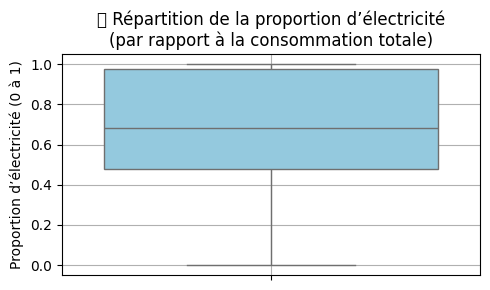

In [6]:

# 📂 Chargement des données nettoyées
df = pd.read_csv("data/2016_Building_Energy_Benchmarking_Purge.csv")

# 🔍 Recherche des colonnes d’électricité
electricity_cols = [col for col in df.columns if 'Electricity' in col and 'kBtu' in col]
total_energy_col = 'SiteEnergyUse(kBtu)'

# ✅ Création de la somme totale de consommation électrique (certaines colonnes sont divisées par usage)
df['Electricity_Use_Total'] = df[electricity_cols].sum(axis=1, skipna=True)

# ⚙️ Calcul du ratio de proportion d’électricité
df['Electricity_Proportion'] = df['Electricity_Use_Total'] / df[total_energy_col]

# 🔁 Nettoyage : garder les cas valides (entre 0 et 1)
df_valid_ratio = df[df['Electricity_Proportion'].between(0, 1)]

# 📊 Statistiques descriptives sur la proportion d’électricité
print(df_valid_ratio['Electricity_Proportion'].describe(percentiles=[.25, .5, .75, .9, .95]))

# 📦 Boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(y=df_valid_ratio['Electricity_Proportion'], color='skyblue')
plt.title("📦 Répartition de la proportion d’électricité\n(par rapport à la consommation totale)")
plt.ylabel("Proportion d’électricité (0 à 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


## ⚡ Poids réel de l’électricité dans la consommation énergétique des bâtiments

### 🎯 Objectif
Quantifier **dans quelle mesure l’électricité contribue à la consommation totale d’énergie** (`SiteEnergyUse(kBtu)`),  
et valider si un modèle basé sur la consommation totale peut capturer l’essentiel des **émissions de gaz à effet de serre**.

---

### 🔍 Méthode
- Extraction des colonnes de consommation électrique (kBtu).
- Somme des valeurs électriques → `Electricity_Use_Total`
- Calcul du ratio :
$
text{Electricity Proportion} = \frac{\text{Electricity\_Use\_Total}}{\text{SiteEnergyUse(kBtu)}}
$

---

### 📊 Résultats statistiques (sur 1578 bâtiments valides)

| Statistique       | Valeur           |
|-------------------|------------------|
| Moyenne           | **68.3 %**        |
| Médiane (50%)     | **68.0 %**        |
| 25e percentile     | 47.7 %           |
| 75e percentile     | 97.5 %           |
| 90e - 95e percentile | **100 %**       |
| Minimum            | 0 %              |
| Maximum            | 100 %            |

---

### 🧠 Interprétation
- Pour **la majorité des bâtiments**, l’électricité constitue la **source principale** d’énergie.
- Pour **plus de 10 % d’entre eux**, elle est **la seule source utilisée**.
- Cela **justifie pleinement** que la consommation totale soit fortement corrélée aux émissions de CO₂,  
puisque l’électricité est **la plus émettrice de CO₂ par kBtu** dans le contexte américain.

---

### ⚠️ Précautions d’usage
- Certains bâtiments combinent gaz, vapeur, fioul… L'effet de levier de l’électricité peut y être atténué.
- Lorsqu'il s'agira modéliser les émissions de CO₂ avec plus de précision, il faudra peut-être:
  - inclure la variable de consommation totale
  - ajouter des indicateurs binaires de source d’énergie
  - intégrer la proportion d’électricité comme feature explicite


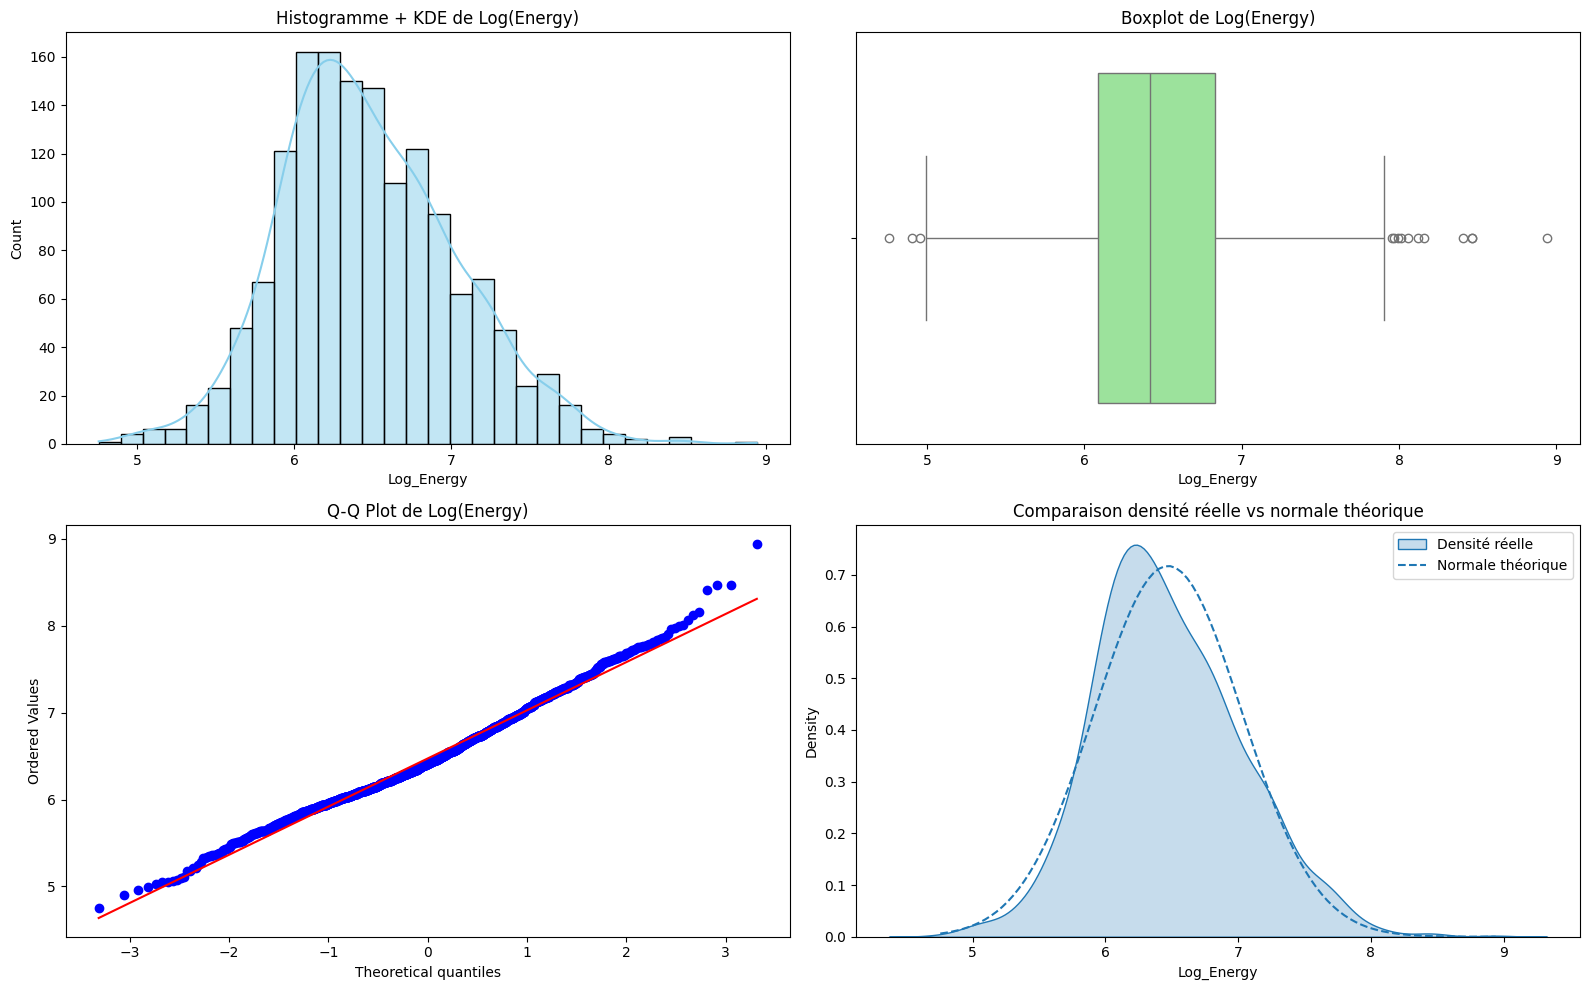

In [4]:
# repartons du bon pied ..
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")


# On garde la variable d'intérêt et on filtre les valeurs manquantes ou nulles
df = df[['SiteEnergyUse(kBtu)']].dropna()
df = df[df['SiteEnergyUse(kBtu)'] > 0]

# Transformation logarithmique pour atténuer les valeurs extrêmes
df['Log_Energy'] = np.log10(df['SiteEnergyUse(kBtu)'])

# Créer une figure avec plusieurs visualisations
plt.figure(figsize=(16, 10))

# 1. Histogramme + courbe KDE
plt.subplot(2, 2, 1)
sns.histplot(df['Log_Energy'], kde=True, bins=30, color='skyblue')
plt.title("Histogramme + KDE de Log(Energy)")

# 2. Boîte à moustaches (boxplot)
plt.subplot(2, 2, 2)
sns.boxplot(x=df['Log_Energy'], color='lightgreen')
plt.title("Boxplot de Log(Energy)")

# 3. Q-Q plot (quantile-quantile plot) pour tester la normalité
plt.subplot(2, 2, 3)
stats.probplot(df['Log_Energy'], dist="norm", plot=plt)
plt.title("Q-Q Plot de Log(Energy)")

# 4. Densité empirique comparée à la courbe normale
plt.subplot(2, 2, 4)
sns.kdeplot(df['Log_Energy'], label='Densité réelle', fill=True)
mean = df['Log_Energy'].mean()
std = df['Log_Energy'].std()
x = np.linspace(df['Log_Energy'].min(), df['Log_Energy'].max(), 100)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normale théorique', linestyle='--')
plt.title("Comparaison densité réelle vs normale théorique")
plt.legend()

plt.tight_layout()
plt.show()

## 🔎 Analyse statistique de la variable log-transformée `Log_Energy`

---

### 🧠 Objectif

Analyser la distribution de `Log_Energy` (transformation logarithmique de `SiteEnergyUse(kBtu)`) pour évaluer :

- Sa **normalité statistique**
- L' **importance des ouliers**
- Son **utilisabilité dans des modèles linéaires**

---

### 📊 1. **Histogramme + KDE (coin haut gauche)**

#### 📌 Abscisse : `Log_Energy` (valeurs transformées en base 10)
#### 📌 Ordonnée : nombre d’occurrences (fréquence)

**Ce qu'on observe :**

- Une **distribution en cloche** centrée autour de 6.5
- Une **courbe KDE (Kernel Density Estimation)** qui lisse la distribution et suggère une forme proche d'une gaussienne
- Une **légère queue à droite** (asymétrie positive)

#### 🧠 Termes techniques :
- **Unimodale** : une seule "bosse", donc pas de segmentation cachée
- **KDE** : une estimation continue de la densité de probabilité, plus lisible qu’un histogramme brut
- **Asymétrie (Skewness)** : ici, la queue à droite indique que quelques bâtiments ont une consommation très élevée

---

### 📦 2. **Boxplot (coin haut droit)**

**Ce qu'on observe :**

- Le corps du boxplot contient la **plupart des bâtiments**
- Quelques **valeurs extrêmes à droite** sont signalées par des cercles

#### 🧠 Termes techniques :
- **Boîte = 50 % central** (entre 1er et 3e quartile)
- **Moustaches = étendue normale** (±1.5×IQR)
- **Outliers** = points au-delà des moustaches (extrêmes)

---

### 📈 3. **Q-Q Plot (coin bas gauche)**

#### 📌 Abscisse : quantiles théoriques d’une loi normale
#### 📌 Ordonnée : quantiles observés dans `Log_Energy`

**Ce qu'on observe :**

- Les points **suivent bien la diagonale**, sauf aux extrémités
- Un **écart en haut à droite** → quelques très grosses consommations

#### 🧠 Termes techniques :
- **Quantiles** : coupures régulières dans la distribution (10 %, 20 %, etc.)
- **Loi normale théorique** : ce que donnerait une variable parfaitement gaussienne
- **Alignement** = distribution normale ; **écarts** = asymétrie ou outliers

---

### 🌊 4. **Densité réelle vs Normale (coin bas droit)**

#### 📌 Abscisse : `Log_Energy`
#### 📌 Ordonnée : densité de probabilité (surface sous la courbe = 1)

**Ce qu'on observe :**

- La **courbe bleue pleine** (densité réelle) suit la **courbe pointillée** (normale) de très près
- Le **pic est légèrement plus haut** et les **extrémités plus étirées** que la normale

#### 🧠 Termes techniques :
- **Densité** : probabilité relative de voir une valeur dans une plage donnée
- **Kurtosis** : mesure de l’"aplatissement" ou de la "queue épaisse"
- Ici : distribution légèrement **leptokurtique** (queues plus épaisses que la normale)

---

### ✅ Conclusion finale

- La transformation logarithmique a **efficacement réduit la variance**, ce qui rend `Log_Energy` :
  - Plus **symétrique**
  - Moins influencée par les valeurs extrêmes
  - **Compatible avec les hypothèses de normalité** (utile pour les modèles linéaires)
- Il reste quelques outliers, mais **contrôlés**, et surtout **interprétables** (très grands bâtiments énergivores)




## 🔍 Relation surface/consommation definitive

Dans cette visualisation :

* La **consommation énergétique totale (kBtu)** a été transformée en **échelle logarithmique** (`Log_Energy`), tout comme la surface utile (`Log_Surface`).
* Les **valeurs extrêmes** (outliers) ont été identifiées via la méthode IQR (1.5 × IQR au-dessus ou en-dessous des quartiles) puis **exclues** du graphique.

### 🎯 Objectifs de cette visualisation :

* Mettre en évidence la tendance **générale** entre la taille d’un bâtiment et sa consommation, **sans être perturbé par des cas extrêmes**.
* Faciliter l’identification d’une **relation linéaire potentielle** sur les données "propres".



✅ Données chargées : (1504, 19)


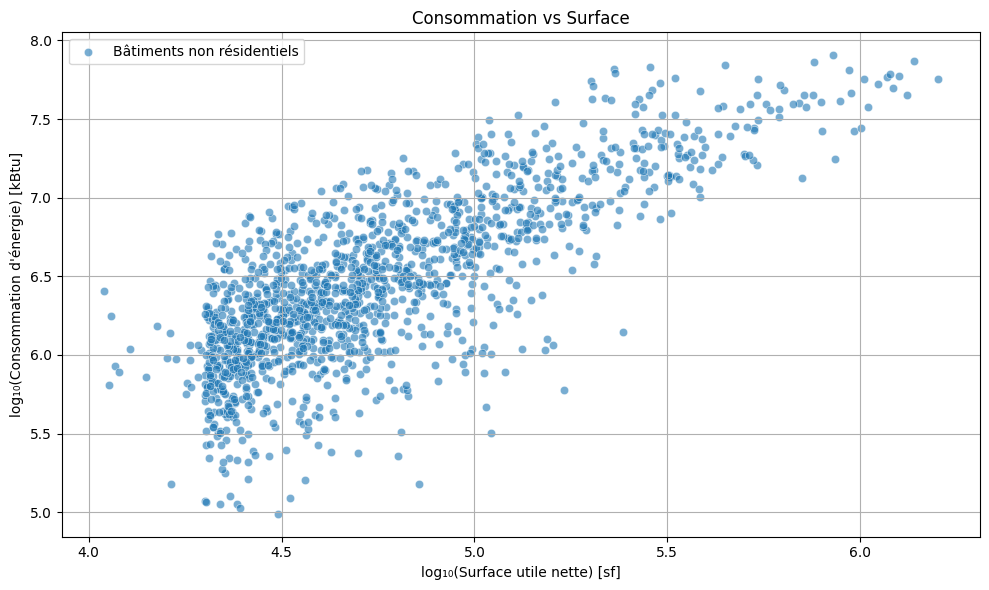

In [8]:

# 🔹 Étape 1 : Charger les données nettoyées
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")
print("✅ Données chargées :", df.shape)

# 🔹 Étape 2 : Log-transformations
df['Log_Surface'] = np.log10(df['PropertyGFABuilding(s)'] + 1)
df['Log_Energy'] = np.log10(df['SiteEnergyUse(kBtu)'] + 1)

# 🔹 Étape 3 : Calcul des bornes IQR
Q1 = df['Log_Energy'].quantile(0.25)
Q3 = df['Log_Energy'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 🔹 Étape 4 : Filtrer les bâtiments normaux (hors outliers)
df_normal = df[(df['Log_Energy'] >= lower_bound) & (df['Log_Energy'] <= upper_bound)]

# 🔹 Étape 5 : Visualisation des bâtiments non résicentiels uniquement
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_normal, x='Log_Surface', y='Log_Energy', alpha=0.6, label="Bâtiments non résidentiels")
plt.xlabel("log₁₀(Surface utile nette) [sf]")
plt.ylabel("log₁₀(Consommation d'énergie) [kBtu]")
plt.title("Consommation vs Surface")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## 📊 Visualisations exploratoires – Interrogations sur les facteurs de consommation

Voici plusieurs représentations graphiques essentielles pour mieux comprendre **les déterminants énergétiques** dans les bâtiments analysés.

---

### 1️⃣ Distribution par type d’usage

> **Boxplot de `SiteEnergyUse(kBtu)` selon `LargestPropertyUseType`**

* Met en évidence l’**hétérogénéité de la consommation selon les usages** (ex. : universités, hôpitaux).
* La **dispersion** et le **nombre d’outliers** sont très variables d’un usage à l’autre.
* Certains types (comme les **Universités**, les **Hôpitaux**, ou les **Data Centers**) présentent des consommations beaucoup plus élevées.

---

### 2️⃣ Surface vs Consommation

> **Scatterplot en log-log, coloré par nombre d’étages**

* Le nuage révèle une **tendance positive** : plus un bâtiment est grand, plus il consomme, ce qui est attendu.
* Les couleurs (nombre d'étages) offrent un aperçu vertical complémentaire : les bâtiments hauts ne sont pas nécessairement plus énergivores à surface égale.

---

### 3️⃣ Année de construction vs consommation 

> **Boxplot selon `YearGroup`, utilisant `SiteEnergyUse(kBtu)`**

---

### 4️⃣ Nombre d’étages vs consommation

> **Scatterplot de `NumberofFloors` vs `SiteEnergyUse(kBtu)`**

* Relation globalement croissante, mais avec **beaucoup de variance**.
* Certains bâtiments peu élevés présentent tout de même une forte consommation (probablement liée à leur fonction).

---

### 5️⃣ Corrélations structurelles

> **Pairplot entre 5 variables clés**

* Cette matrice visuelle permet de **repérer les corrélations fortes**, comme :

  * `PropertyGFABuilding(s)` avec `SiteEnergyUse(kBtu)`
  * `GFA` et `LargestPropertyUseTypeGFA`

  * `PropertyGFABuilding(s)` ↔ `SiteEnergyUse(kBtu)`
  *  `PropertyGFABuilding(s)` ↔ `LargestPropertyUseTypeGFA`
  *  ...


C:\Users\karap\AppData\Local\Temp\ipykernel_26320\1241258927.py:11: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


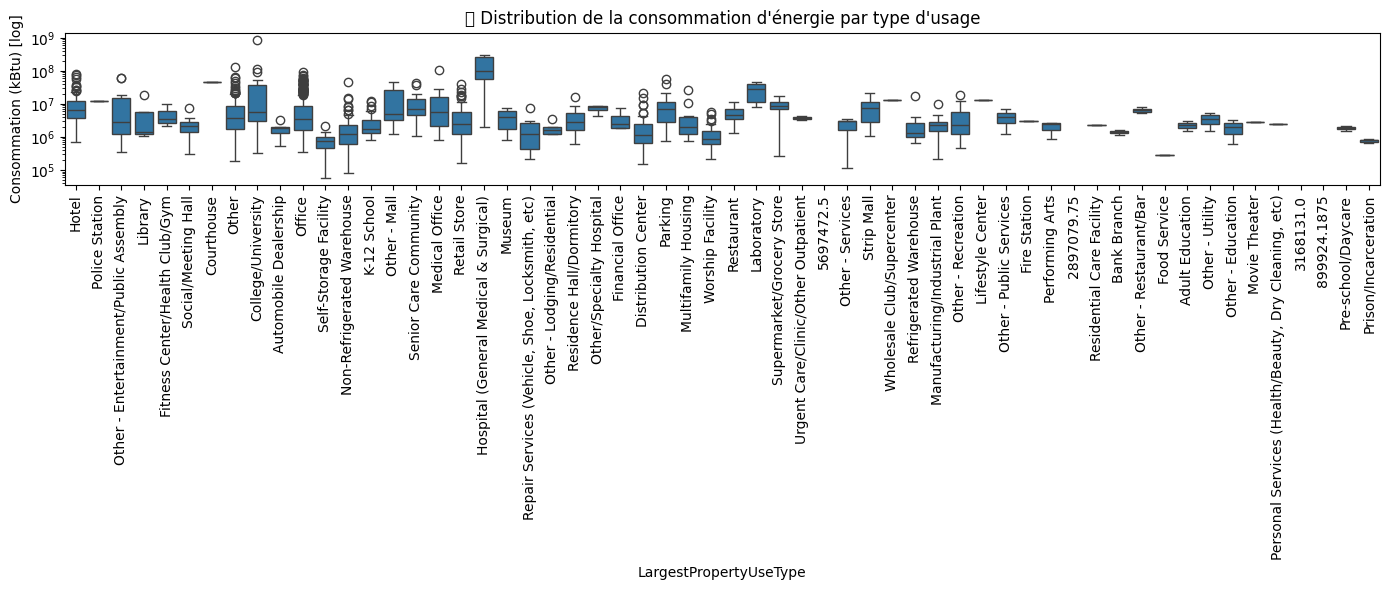

In [18]:


# Chargement des données
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# Boxplot : consommation selon le type d’usage
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='LargestPropertyUseType', y='SiteEnergyUse(kBtu)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title("📦 Distribution de la consommation d'énergie par type d'usage")
plt.ylabel("Consommation (kBtu) [log]")
plt.tight_layout()
plt.show()




## 📦 Analyse de la distribution de la consommation d’énergie par type d’usage (`LargestPropertyUseType`)

### 🎯 Objectif du graphique :

Ce **boxplot logarithmique** a pour but de visualiser la **distribution de la consommation énergétique brute** (`SiteEnergyUse(kBtu)`) en fonction du **type d’usage principal** du bâtiment (`LargestPropertyUseType`).

---

### 🧮 Lecture du graphique :

* Chaque boîte représente l’**étendue interquartile** (IQR) de la consommation pour un type de bâtiment donné.
* La ligne centrale de la boîte est la **médiane**.
* Les cercles hors de la boîte sont des **outliers**, au sens statistique.
* L’axe vertical étant en **échelle logarithmique**, chaque saut représente un ordre de grandeur (exponentiel).

---

### 📊 Observations clés :

#### 🔝 Consommations très élevées :

* Les **Hôpitaux**, **Universités**, **Data Centers** (autour de *College/University*, *Hospital*, *Other*) montrent une consommation très élevée et variable, avec de **nombreux outliers** vers le haut.
* Cela reflète des activités continues, énergivores (ex. : équipements médicaux, informatique, laboratoires).

#### 🏢 Consommations modérées à élevées :

* **Office**, **Retail Store**, **K-12 Schools**, **Hotel**, ou **Fitness Center/Health Club** ont une distribution plus serrée, mais restent assez énergivores.
* Certains **bureaux** ont des pics de consommation, probablement dus à des équipements ou à des tailles très différentes.

#### 🔽 Consommations plus faibles :

* Des types comme **Library**, **Social/Meeting Hall**, **Parking**, **Religious Building**, ou **Bank** affichent des consommations plus faibles, avec peu d’outliers.
* Cela s’explique souvent par des usages intermittents ou des surfaces modestes.

---

### ⚠️ Limitations / Attention :

* Certains types sont représentés par peu de bâtiments, ce qui peut fausser l’interprétation (ex. : catégories rares comme *Movie Theater*, *Prison*, etc.).
* L’usage **"Other"** contient une grande hétérogénéité qui mériterait d’être explorée ou reclassée.



### 🧠 En résumé :

Ce graphe met en lumière **l’importance de segmenter les bâtiments par usage** pour mieux comprendre leurs profils énergétiques. Il révèle aussi des **variations internes importantes** dans certains types, incitant à une exploration plus fine.


C:\Users\karap\AppData\Local\Temp\ipykernel_21812\2687332856.py:10: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


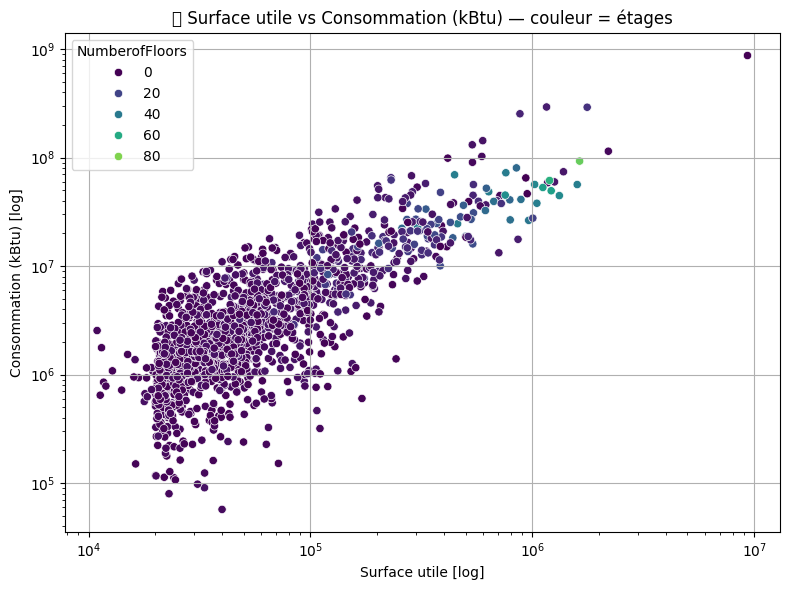

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PropertyGFABuilding(s)', y='SiteEnergyUse(kBtu)',
                hue='NumberofFloors', palette='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title("🔎 Surface utile vs Consommation (kBtu) — couleur = étages")
plt.xlabel("Surface utile [log]")
plt.ylabel("Consommation (kBtu) [log]")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\karap\AppData\Local\Temp\ipykernel_21812\652611475.py:12: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


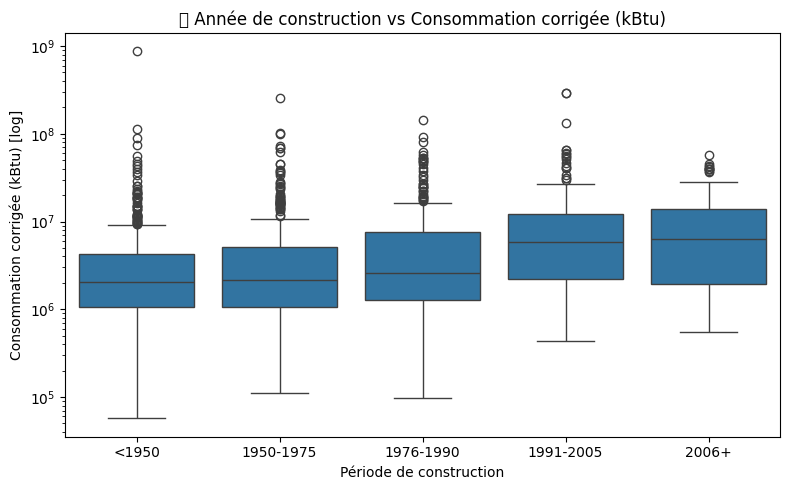

In [14]:
# Découpage des années de construction
df['YearGroup'] = pd.cut(df['YearBuilt'], bins=[0, 1950, 1975, 1990, 2005, 2025],
                         labels=['<1950', '1950-1975', '1976-1990', '1991-2005', '2006+'])

# Boxplot : consommation selon tranche d’année
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='YearGroup', y='SiteEnergyUse(kBtu)')
plt.yscale('log')
plt.title("🏗️ Année de construction vs Consommation corrigée (kBtu)")
plt.ylabel("Consommation corrigée (kBtu) [log]")
plt.xlabel("Période de construction")
plt.tight_layout()
plt.show()



### 🏗️ Année de construction vs consommation énergétique brute

#### 🎯 Objectif

Ce graphique explore le lien entre la **date de construction d’un bâtiment** (découpée en tranches historiques) et sa **consommation brute d’énergie (kBtu)**.
L’idée sous-jacente est d’évaluer si les bâtiments plus récents sont **structurellement plus performants** en matière de consommation.

---

#### 🧰 Méthodologie

* La variable **`YearBuilt`** a été découpée en 5 périodes :

  * `<1950`
  * `1950-1975`
  * `1976-1990`
  * `1991-2005`
  * `2006+`

* Pour chaque tranche, un **boxplot** de la consommation énergétique brute a été tracé :

  * Échelle **logarithmique** sur l’axe des ordonnées pour lisser les extrêmes
  * Visualisation des **médianes**, de la **dispersion** et des **outliers**

---

#### 📊 Interprétation

* 🟦 **Augmentation progressive des médianes** :
  Contrairement à ce que l’on pourrait attendre, **les bâtiments plus récents ont une consommation médiane plus élevée** que ceux construits avant 1990.

* 📉 **Faible amélioration de l'efficacité apparente** :
  Cela peut sembler contre-intuitif, mais plusieurs facteurs l’expliquent :

  * Les bâtiments récents sont souvent **plus grands ou multifonctionnels**
  * L’intensité d’usage (climatisation, informatique, éclairage) est **plus élevée aujourd’hui**
  * Il s'agit ici de **consommation brute**, non normalisée par la surface ou l’usage

* ⚠️ **Présence d'outliers extrêmes** dans toutes les tranches :
  Cela souligne une grande variabilité d’un bâtiment à l’autre, peu importe la période.

---

#### 🧠 Conclusion

La **date de construction seule** ne permet pas de conclure à une **meilleure performance énergétique**. Une analyse **ajustée par la surface**, le type d’usage ou des indicateurs normalisés serait nécessaire pour dégager des tendances plus fiables.



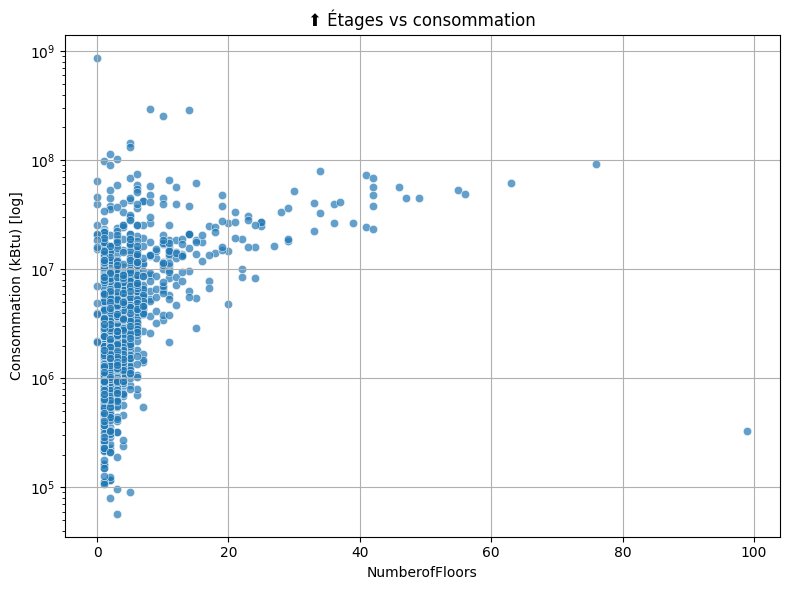

In [15]:
# Scatterplot : Hauteur vs consommation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='NumberofFloors', y='SiteEnergyUse(kBtu)', alpha=0.7)
plt.yscale('log')
plt.title("⬆️ Étages vs consommation")
plt.ylabel("Consommation (kBtu) [log]")
plt.grid(True)
plt.tight_layout()
plt.show()



---

## ⬆️ Analyse : Nombre d'étages vs consommation d'énergie 

### 🎯 Objectif du graphique :

Ce **nuage de points (scatterplot)** représente la relation entre le **nombre d’étages (`NumberofFloors`)** d’un bâtiment et sa **consommation énergétique brute (`SiteEnergyUse(kBtu)`)**, sur une échelle **logarithmique** pour lisser les grandes disparités de valeurs.

---

### 🔍 Lecture du graphique :

* **Axe X** : Nombre d'étages (échelle linéaire)
* **Axe Y** : Consommation brute d’énergie (échelle logarithmique)
* Chaque point = un bâtiment
* Échelle log sur l'axe Y : rend visible les grandes consommations

---

### 📊 Observations clés :

#### 1. **Forte concentration en bas de l’échelle** :

* La grande majorité des bâtiments ont entre **1 et 10 étages**.
* Dans cette tranche, la **consommation varie énormément**, ce qui suggère que **le nombre d’étages n’est pas le seul déterminant**.

#### 2. **Dispersion verticale importante** :

* Pour un même nombre d’étages (ex. 5), la consommation peut **varier de plusieurs ordres de grandeur** (de (10^5) à (10^9) kBtu).

#### 3. **Quelques très hauts bâtiments** (> 40 étages) :

* Ces bâtiments consomment **souvent plus**, mais pas toujours proportionnellement à leur taille.
* Cela peut refléter une **meilleure efficacité énergétique** dans certains gratte-ciel récents.

#### 4. **Corrélation faible** :

* Bien qu’on puisse s’attendre à ce que **plus d’étages = plus de consommation**, le lien est **peu clair** ici.
* Cela s’explique par des **facteurs confondants** : usage, surface par étage, isolation, climatisation, etc.

---

### 🧠 En résumé :

Ce graphique montre que le **nombre d’étages seul n’est pas un prédicteur fiable** de la consommation énergétique brute. Il faut le croiser avec d’autres facteurs (surface utile, type d’usage, date de construction) pour comprendre la variabilité observée.


C:\Users\karap\AppData\Local\Temp\ipykernel_21812\145282042.py:11: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


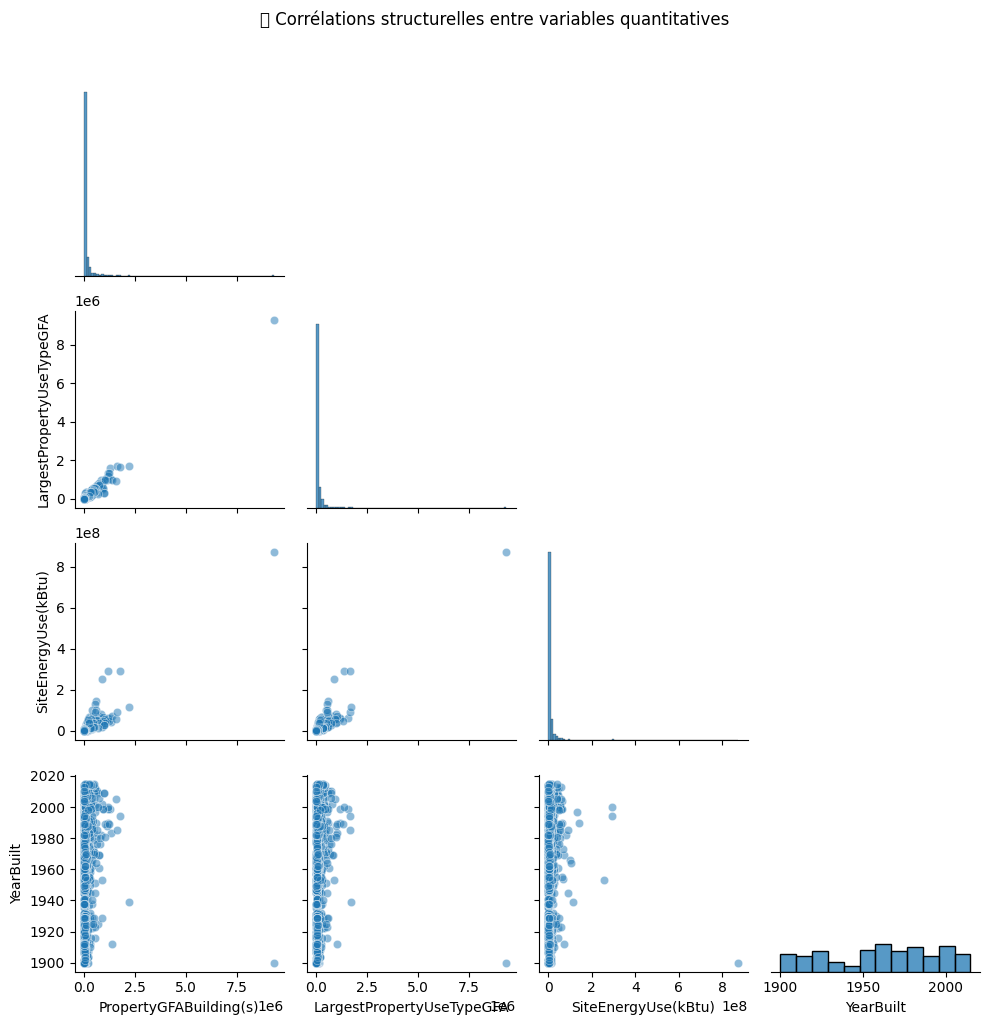

In [16]:
# Pairplot sur les variables clés
features = [
    'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA',
    'SiteEnergyUse(kBtu)',
     'YearBuilt'
]

sns.pairplot(df[features].dropna(), corner=True, plot_kws={'alpha': 0.5})
plt.suptitle("🔗 Corrélations structurelles entre variables quantitatives", y=1.02)
plt.tight_layout()
plt.show()




### 🔍 Analyse des corrélations structurelles entre variables quantitatives

#### 🎯 Objectif

L’objectif de ce graphique est d’explorer visuellement les relations entre plusieurs variables structurantes du bâtiment :

* **`PropertyGFABuilding(s)`** : surface utile du bâtiment
* **`LargestPropertyUseTypeGFA`** : surface dédiée à l’usage principal
* **`SiteEnergyUse(kBtu)`** : consommation énergétique brute
* **`YearBuilt`** : année de construction

---

#### 🧰 Méthodologie

Nous utilisons ici un **pairplot** (`sns.pairplot`) avec l’option `corner=True` pour ne pas afficher les redondances, ce qui permet :

* De visualiser chaque relation croisée sous forme de nuages de points
* De détecter visuellement des relations linéaires, exponentielles ou l'absence de relation
* D’identifier des regroupements, tendances ou outliers

---

#### 📊 Observations

* **PropertyGFABuilding(s) ↔ SiteEnergyUse(kBtu)**
  → Une corrélation claire : les plus grands bâtiments consomment logiquement plus d’énergie, mais avec une dispersion qui indique que la taille ne suffit pas à expliquer toute la variation.

* **PropertyGFABuilding(s) ↔ LargestPropertyUseTypeGFA**
  → Corrélation très forte (proche de 1), ce qui est attendu puisque cette dernière est un sous-ensemble de la surface totale. Cela pourrait justifier la suppression d'une des deux variables pour éviter la redondance.

* **YearBuilt ↔ Consommation / Surfaces**
  → Pas de tendance claire. Les bâtiments anciens comme récents peuvent avoir une consommation élevée ou faible, ce qui suggère que l’année seule ne suffit pas à expliquer la performance énergétique.

* **Outliers évidents**
  → Certains points se détachent très nettement du nuage principal (surtout sur la consommation), ce qui souligne l’importance d’un traitement des valeurs extrêmes.

---

#### 🧠 Interprétation globale

Ce type de visualisation est essentiel dans une démarche de **pré-modélisation** ou de **réduction de dimensions** :

* Il permet d’**identifier des dépendances fortes** entre variables (qui biaiseraient un modèle)
* Il révèle **les relations non linéaires** ou des sous-groupes cachés
* Il aide à décider **quelles variables conserver**, transformer ou combiner




### Préparation des features pour la modélisation

✅ Données chargées : (1504, 19)
⚠️ Nombre d'outliers détectés (Z-score => 2.8) : 9


C:\Users\karap\AppData\Local\Temp\ipykernel_26320\1630266869.py:34: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


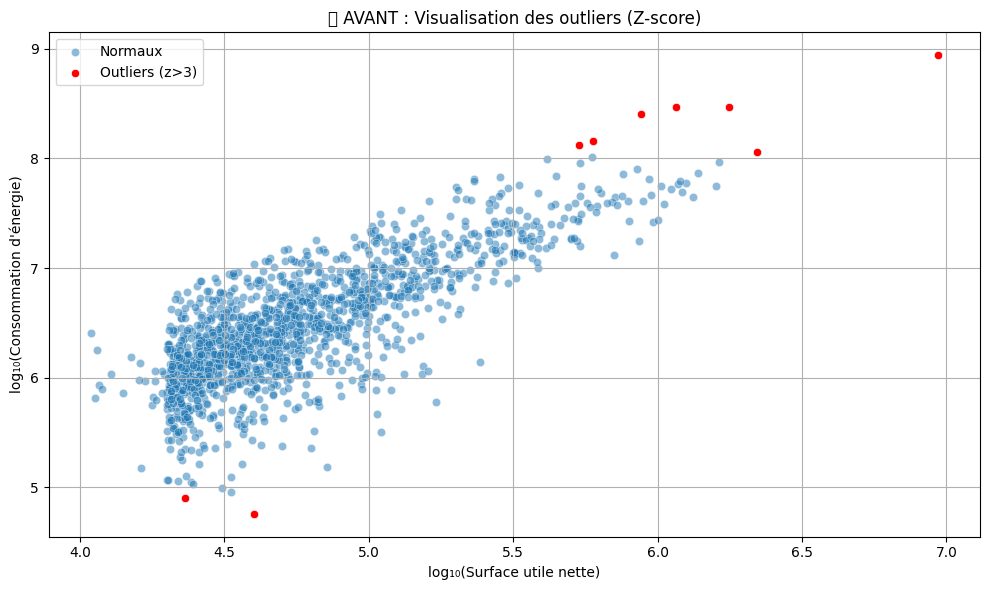

💬 Supprimer ces outliers extrêmes ? (o/n) :  o


✅ Outliers supprimés. Nouvelles dimensions : (1491, 7)


C:\Users\karap\AppData\Local\Temp\ipykernel_26320\1630266869.py:54: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


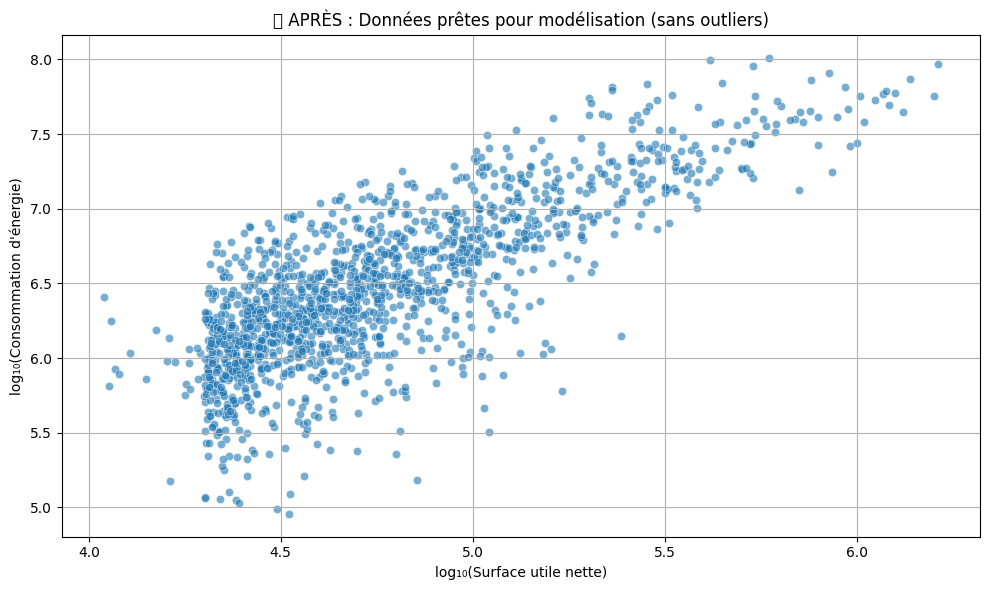

💾 Fichier final enregistré dans : data/zscore_cleaned_energy_data.csv


In [44]:
from scipy.stats import zscore

# 🔹 Étape 1 : Chargement
file_path = "data/cleaned_2016_Building_Energy_Benchmarking_ML.csv"
df = pd.read_csv(file_path)
print(f"✅ Données chargées : {df.shape}")

# 🔹 Étape 2 : Nettoyage des colonnes d'intérêt
df = df[['OSEBuildingID', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)']].dropna()
df = df[df['PropertyGFABuilding(s)'] > 0]
df = df[df['SiteEnergyUse(kBtu)'] > 0]

# 🔹 Étape 3 : Log-transform + Z-score
df['Log_Surface'] = np.log10(df['PropertyGFABuilding(s)'])
df['Log_Energy'] = np.log10(df['SiteEnergyUse(kBtu)'])

df['Z_Energy'] = zscore(df['Log_Energy'])

# 🔹 Étape 4 : Détection des outliers (|z| >= 2.8)
df['Outlier'] = df['Z_Energy'].abs() >= 2.8
n_outliers = df['Outlier'].sum()

print(f"⚠️ Nombre d'outliers détectés (Z-score => 2.8) : {n_outliers}")

# 🔹 Étape 5 : Visualisation AVANT suppression
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Log_Surface', y='Log_Energy', alpha=0.5, label="Normaux")
sns.scatterplot(data=df[df['Outlier']], x='Log_Surface', y='Log_Energy', color='red', label="Outliers (z>3)")
plt.xlabel("log₁₀(Surface utile nette)")
plt.ylabel("log₁₀(Consommation d'énergie)")
plt.title("📌 AVANT : Visualisation des outliers (Z-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Étape 6 : Choix utilisateur
choice = input("💬 Supprimer ces outliers extrêmes ? (o/n) : ").lower()

if choice == "o":
    df_cleaned = df[~df['Outlier']].copy()
    print(f"✅ Outliers supprimés. Nouvelles dimensions : {df_cleaned.shape}")
else:
    df_cleaned = df.copy()
    print("ℹ️ Aucune suppression faite.")

# 🔹 Étape 7 : Visualisation APRÈS suppression
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Log_Surface', y='Log_Energy', alpha=0.6)
plt.xlabel("log₁₀(Surface utile nette)")
plt.ylabel("log₁₀(Consommation d'énergie)")
plt.title("✅ APRÈS : Données prêtes pour modélisation (sans outliers)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Étape 8 : Sauvegarde
output_path = "data/zscore_cleaned_energy_data.csv"
df_cleaned.drop(columns=['Log_Surface', 'Log_Energy', 'Z_Energy', 'Outlier']).to_csv(output_path, index=False)
print(f"💾 Fichier final enregistré dans : {output_path}")


## 🏗️ Feature Engineering – Finalisation avec "Neighborhood"

---

### 🎯 Objectif

Créer des **variables pertinentes, prédictives et fiables** pour modéliser la consommation d’énergie d’un bâtiment, sans fuite d’information. Nous intégrons ici une nouvelle variable **géographique** : le **quartier (`Neighborhood`)**.

---

### 🔹 `BuildingAge`  
Mesure la **vétusté du bâtiment**. Elle peut impacter les équipements et l’isolation.

---

### 🔹 `log_surface`  
Transforme la surface utile avec `log(1 + x)` pour :
- Réduire l’impact des valeurs extrêmes
- Approcher une distribution normale

---

### 🔹 `surface_bin` + `Size_*`  
Regroupe les bâtiments en catégories de taille (`XS`, `S`, ..., `XXL`), puis :
- Encodage **one-hot**
- Permet au modèle de **capturer des effets de seuil** liés à la taille

---

### 🔹 `surface_per_floor`  
Indique si le bâtiment est étalé ou en hauteur :
- Influence les besoins en chauffage, ventilation, éclairage
- Feature numérique continu, utile pour la régression

---

### 🔹 `NeighborhoodGrouped` + `Nhood_*`  
Représente le **quartier d’implantation du bâtiment** :
- Quartiers trop rares sont regroupés en `Other`
- Encodage **one-hot** pour exploitation par les modèles
- Capture d’effets **géographiques ou socio-économiques** potentiels sur la consommation

---

### ❌ Ce qu’on a retiré :
| Variable | Raisons |
|----------|---------|
| `energy_per_m2`, `efficiency_score` | Risque de **data leakage** |
| `PrimaryPropertyType` (`Usage_*`)   | Trop de **cardinalité** pour l’instant |
| `ZipCode`                           | Trop bruité et redondant avec `Neighborhood` |

---

### ✅ Résultat
Ce jeu de données est maintenant **structuré, stable et exploitable**, pour être injecté directement dans une pipeline d’entraînement.


In [22]:
import pandas as pd
import numpy as np

# 📂 Chargement
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# 🎯 Cible
target = 'SiteEnergyUse(kBtu)'

# 🔹 1. Âge du bâtiment
df['BuildingAge'] = 2025 - df['YearBuilt']
df['BuildingAge'] = df['BuildingAge'].clip(lower=0)

# 🔹 2. Transformation logarithmique de la surface
df['log_surface'] = np.log1p(df['PropertyGFABuilding(s)'])

# 🔹 3. Tranches de surface
df['surface_bin'] = pd.cut(df['PropertyGFABuilding(s)'],
                           bins=[0, 5000, 20000, 50000, 100000, 200000, np.inf],
                           labels=["XS", "S", "M", "L", "XL", "XXL"])

# 🔹 4. Encodage one-hot des catégories de surface
df = pd.get_dummies(df, columns=['surface_bin'], prefix='Size', drop_first=True)

# 🔹 5. Surface par étage
df['surface_per_floor'] = np.where(df['NumberofFloors'] > 0,
                                   df['PropertyGFABuilding(s)'] / df['NumberofFloors'],
                                   np.nan)

# 🔹 6. Neighborhood (quartier)
df['Neighborhood'] = df['Neighborhood'].fillna('Unknown')
neighborhood_counts = df['Neighborhood'].value_counts()
rare_neighborhoods = neighborhood_counts[neighborhood_counts < 10].index
df['NeighborhoodGrouped'] = df['Neighborhood'].replace(rare_neighborhoods, 'Other')
df = pd.get_dummies(df, columns=['NeighborhoodGrouped'], prefix='Nhood', drop_first=True)

# 💾 Sauvegarde
df.to_csv("data/feature_engineered_2016_energy.csv", index=False)
print("✅ Données enrichies et sauvegardées.")


✅ Données enrichies et sauvegardées.




### ✅ Pourquoi *convertir en dummies* ?

**"Convertir une variable en dummies"** signifie **transformer une variable catégorielle** (texte ou étiquette) en plusieurs **colonnes binaires (0 ou 1)** que les algorithmes de machine learning peuvent comprendre.

---

### 🔄 Exemple simple

Prenons une variable `PropertyTypeGrouped` avec 3 catégories :

| PropertyTypeGrouped |
| ------------------- |
| Office              |
| Hotel               |
| Warehouse           |

Après conversion en *dummies*, on obtient :

| Usage_Hotel | Usage_Office | Usage_Warehouse |
| ----------- | ------------ | --------------- |
| 0           | 1            | 0               |
| 1           | 0            | 0               |
| 0           | 0            | 1               |

Chaque ligne a **un seul 1**, indiquant **le type de bâtiment**.
Le reste vaut 0 car ce n’est **pas ce type-là**.

---

### 🤖 Pourquoi on fait ça ?

* Les **algorithmes de ML** (régression linéaire, arbres, SVM, etc.) **ne comprennent pas le texte**.
* Ils **ne doivent pas interpréter** une catégorie comme **un ordre numérique** (ex: Office=1, Hotel=2… serait faux !)
* Les *dummies* permettent de dire **"est-ce que c’est ce type ou pas"**, **sans biais numérique**.

---

### 🧠 Astuce : `drop_first=True`

Dans `pd.get_dummies(..., drop_first=True)`, on supprime **une colonne** pour éviter la **multicolinéarité** (dans un modèle linéaire, sinon les colonnes sont linéairement dépendantes).
Cela ne change rien à l’information, car on peut la **reconstruire par différence**.




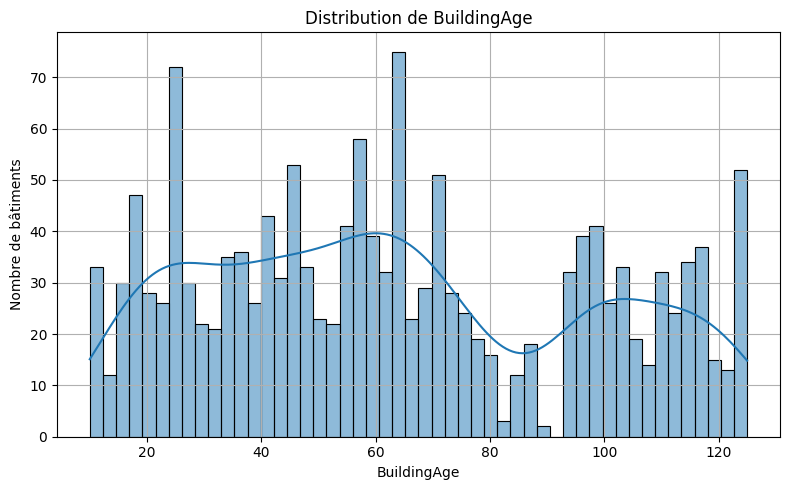

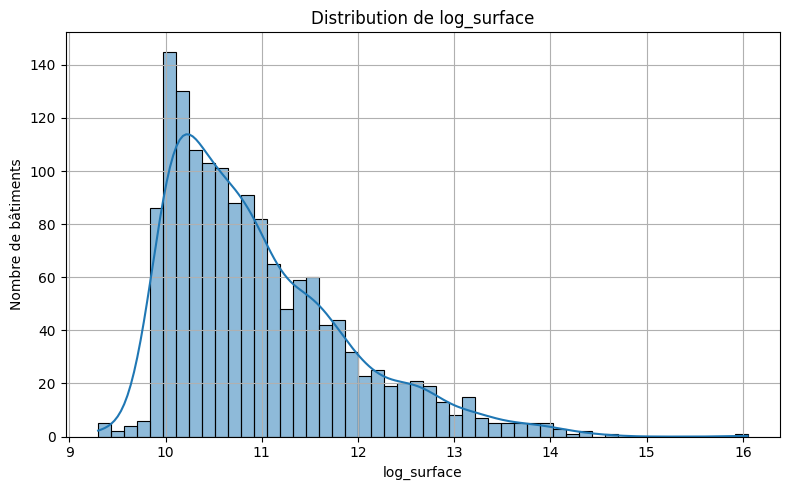

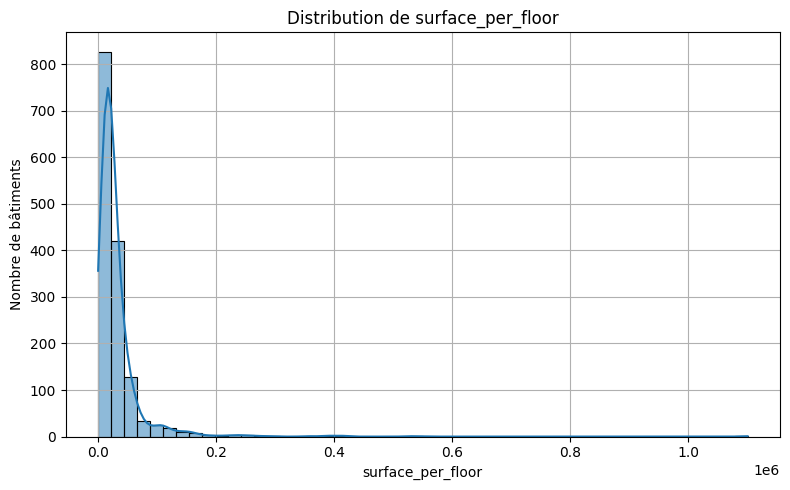

In [24]:


# 📂 Chargement du fichier enrichi
df = pd.read_csv("data/feature_engineered_2016_energy.csv")

# 🗂️ Liste des variables dérivées à visualiser
variables = [
    'BuildingAge',
    'log_surface',
    'surface_per_floor'
]

# 🎨 Tracer les histogrammes avec courbes KDE
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[var].dropna(), kde=True, bins=50)
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel("Nombre de bâtiments")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
